In [ ]:
#Let's implement the 2003 Bag Of Words Paper

In [ ]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [ ]:
#Data:
names = open("names.txt").read().splitlines()
print(f"{len(names)=}")

# Build Vocab
itos = {i+1:s for i,s in enumerate(sorted(set("".join(names))))}
itos[0] = '.'
stoi = {s:i for i,s in itos.items()}

In [103]:
#Data Set Creation:
def create_data(names):
    x, y = [], []
    context_len = 3
    xchar, ychar = [], []
    buff = [0]*context_len
    buff = [itos[b] for b in buff]
    for name in names:
        augmented_name = buff + list(name) + ['.']
        for i in range(len(augmented_name)-context_len):
            xi = augmented_name[i:i+context_len ]
            yi = augmented_name[i+context_len]
            #print(f"{xi} -------> {yi}")
            xchar.append(xi)
            ychar.append(yi)
            x.append([stoi[d] for d in xi])
            y.append(stoi[yi])
    
    return torch.tensor(x), torch.tensor(y)


In [107]:
#Create Minibathces:
import random
random.shuffle(names)

train = int(0.8 * len(names))
val = int(0.1 * len(names))
test = int(0.1 * len(names))

train, test, val

(25626, 3203, 3203)

In [108]:

Xtr, Ytr = create_data(names[:train])
Xval, Yval = create_data(names[train:train+val])
Xtest, Ytest = create_data(names[train+val:train+val+test])

In [110]:
Xtr[:5,:]

tensor([[ 0,  0,  0],
        [ 0,  0, 12],
        [ 0, 12,  1],
        [12,  1, 14],
        [ 1, 14,  1]])

In [ ]:
#Let's create the embeddings
C = torch.rand((27,2))
emb = C[X]
emb.shape

In [ ]:
#Lets create the NN
Xtr = torch.cat(torch.unbind(emb,1),dim=1)
print(Xtr.shape)


In [ ]:
# Layer 1 has 100 neurons
# Layer 2 is Softmax
# 6 --> 100 --> 27 --> Softmax

n1 = 100
n2 = 200
n3 = 27
layers = [n1,n2,n3]

def paramsetting(prev,layers):
        W = []
        b = []
        for layer in layers:
            W.append(torch.rand((prev,layer),requires_grad=True))
            b.append(torch.rand((layer),requires_grad=True))
            prev = layer
        return W,b


def mainloop(X,Y, layers,iterations = 10, step_size = 0.9):
    C = torch.rand((27,2),requires_grad=True)
    W,b = paramsetting(6,layers)
    losses = []
    params = [C] + W + b
    for _ in range(iterations):
        loss = forward()
        losses.append(loss.data)
        print(f"{loss=}")
        backward(loss)
    
    return losses

def forward(C, W, b):
    emb = C[X]
    H = emb.view(-1,6)
    for Wi,bi in zip(W,b):
        H = torch.tanh(H@Wi + bi)
    loss = F.cross_entropy(H,Y)
    return loss

def backward(loss, params,step_size = 0.1):
    for param in params:
        param.grad = None

    loss.backward()

    for param in params:
        param.data += -step_size * param.grad

    # return backward(forward(C,W,b))
    
    

#losses = mainloop(X,Y,[100,27])
         

loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)
loss=tensor(3.2958, grad_fn=<NllLossBackward0>)


In [186]:
# I don't really like losing so I'm going to try and figure out what went wrong up there.
# My Guess is that I'm not actually updating any of the params

class bmodel:
    def __init__(self, X,Y, layers, emb_dim,context_len,bins):
        self.X = X
        self.Y = Y
        self.lr = 0.1
        self.layers = layers
        self.emb_dim = emb_dim
        self.bins = bins
        self.context_len = context_len
        self.params = []

    def _init_params(self):
        self.C = torch.randn((self.bins,self.emb_dim),requires_grad=True) # This should give a lookup for every character
        print(self.C.shape)
        #self.params.append(self.C)
        prev = self.emb_dim * self.context_len
        for layer in self.layers:
            Wi = torch.randn((prev,layer),requires_grad=True)
            print(f"{Wi.shape=}")
            bi = torch.randn((layer),requires_grad=True)
            print(f"{bi.shape}")
            self.params.append((Wi, bi))
            prev = layer
    
    def forward(self):
        emb = self.C[self.X]
        H = emb.view(-1,self.emb_dim*self.context_len)
        for Wi,bi in self.params:
            H = torch.tanh(H@Wi+bi)
        self.loss = F.cross_entropy(H,self.Y)

    def backward(self):
        self.C.grad = None
        for Wi,bi in self.params:
            Wi.grad = None
            bi.grad = None

        self.loss.backward()
        for Wi,bi in self.params:
            print(Wi.grad)
            Wi.data += -self.lr* Wi.grad
            bi.data += -self.lr* bi.grad

        #print(f"new W1 = {self.params[0]}")

        self.C.data += -self.lr * self.C.grad

        
        


In [189]:
#Sanity Tests:
test_model = bmodel(X=Xtr,Y=Ytr,layers= [100,27],emb_dim=2,context_len=3,bins=27)
test_model._init_params()
test_model.forward()
print(test_model.params[0])


torch.Size([27, 2])
Wi.shape=torch.Size([6, 100])
torch.Size([100])
Wi.shape=torch.Size([100, 27])
torch.Size([27])
(tensor([[-9.2985e-01, -3.0976e-01,  5.1240e-01,  3.2446e-01, -1.9710e+00,
          1.1603e+00, -9.0764e-02, -4.4662e-01,  1.2599e+00,  7.0690e-01,
          8.9325e-01, -1.6977e+00, -2.1893e+00,  6.6703e-01,  7.1029e-01,
          2.0624e-01,  3.0119e-01, -8.6906e-01, -1.4270e+00, -4.2118e-01,
         -2.4960e-01,  3.0082e-01,  2.7032e+00,  2.8511e-01,  1.0936e+00,
          8.8171e-01, -3.9861e-01,  1.1729e+00,  1.5506e+00,  2.8473e-01,
          1.0396e+00,  1.9047e-01,  6.0563e-01, -1.6977e+00, -3.6744e-01,
         -1.1459e-01, -1.4633e+00,  6.1510e-01,  4.4789e-01, -7.8789e-01,
          7.8657e-01, -5.7071e-01,  7.8821e-01,  7.0626e-01,  7.0715e-01,
         -3.5607e-01,  1.5498e-01, -4.6599e-01,  1.1492e+00,  1.4642e+00,
         -2.1175e-01, -1.1569e+00,  7.5770e-01,  5.6135e-01,  1.9615e+00,
          8.2764e-01, -6.6828e-01,  3.8399e-01, -8.6207e-01, -1.2442e

In [190]:
test_model.backward()

tensor([[-3.6375e-03,  2.8625e-03,  7.0657e-03, -5.8386e-05,  1.1307e-04,
         -6.0297e-04,  2.8253e-03, -4.3088e-04,  1.6431e-03, -1.3940e-03,
         -9.4472e-04, -1.0698e-03,  4.8563e-04,  5.4526e-04, -2.2520e-03,
          4.1413e-03,  5.1512e-05, -6.2167e-04,  3.6605e-03, -4.0753e-03,
          5.4559e-04,  2.7826e-03,  1.2886e-03, -2.4251e-03,  1.5662e-03,
         -1.6674e-03,  4.1529e-03,  3.5581e-03,  1.9231e-03, -4.4803e-04,
         -8.7476e-04,  1.1891e-03,  7.1295e-04,  7.6692e-04,  1.5674e-03,
         -1.4976e-03, -2.2231e-03, -6.5801e-04,  2.6050e-03, -2.6438e-03,
         -3.3949e-03,  1.9200e-03, -2.1578e-03, -8.1866e-05, -2.0135e-03,
         -4.1314e-03, -3.6810e-04, -1.6515e-03,  1.5901e-03,  3.3121e-03,
          4.1064e-03,  2.4657e-03,  4.5222e-03, -7.3065e-04, -3.6873e-03,
          9.6014e-04, -3.1614e-03,  4.7406e-05,  1.6971e-03, -6.8719e-05,
          4.6115e-04, -1.4878e-03, -1.9241e-03, -4.9684e-04,  1.9279e-03,
         -1.4099e-04,  9.8349e-04, -2.

In [191]:

test_model.forward()
print(test_model.params[0])
loss2 = test_model.loss

print(f"{loss1=},{loss2=}")

(tensor([[-9.2949e-01, -3.1004e-01,  5.1169e-01,  3.2447e-01, -1.9710e+00,
          1.1603e+00, -9.1047e-02, -4.4658e-01,  1.2597e+00,  7.0704e-01,
          8.9334e-01, -1.6976e+00, -2.1894e+00,  6.6697e-01,  7.1052e-01,
          2.0582e-01,  3.0118e-01, -8.6900e-01, -1.4273e+00, -4.2077e-01,
         -2.4965e-01,  3.0054e-01,  2.7031e+00,  2.8536e-01,  1.0935e+00,
          8.8188e-01, -3.9903e-01,  1.1726e+00,  1.5504e+00,  2.8478e-01,
          1.0397e+00,  1.9035e-01,  6.0556e-01, -1.6977e+00, -3.6759e-01,
         -1.1444e-01, -1.4631e+00,  6.1517e-01,  4.4763e-01, -7.8762e-01,
          7.8691e-01, -5.7090e-01,  7.8843e-01,  7.0626e-01,  7.0735e-01,
         -3.5566e-01,  1.5501e-01, -4.6583e-01,  1.1490e+00,  1.4639e+00,
         -2.1216e-01, -1.1571e+00,  7.5725e-01,  5.6142e-01,  1.9618e+00,
          8.2754e-01, -6.6797e-01,  3.8399e-01, -8.6224e-01, -1.2441e+00,
          1.4293e+00,  2.4146e+00, -9.3862e-01,  6.9080e-01,  4.4657e-01,
         -9.3457e-01, -9.6348e-01,  1

In [ ]:
#let's try Karpathy's approach:
#first creating minibatches

In [111]:
Xtr.shape, Ytr.shape

(torch.Size([182426, 3]), torch.Size([182426]))

In [112]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [113]:
sum(p.nelement() for p in parameters)

11897

In [114]:
for p in parameters:
    p.requires_grad = True

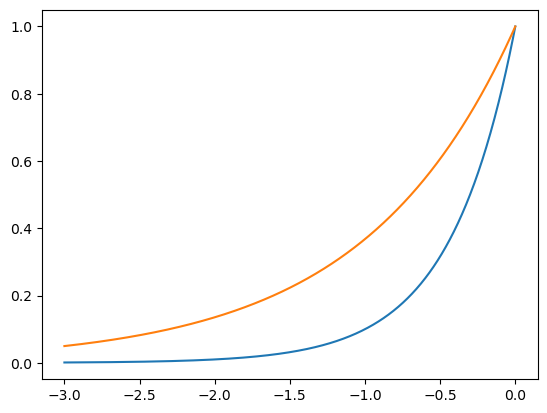

In [119]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
lrs2 = torch.exp(lre)
plt.plot(lre,lrs,lre,lrs2)

In [120]:
# Again from Karpathy
lri = []
lossi = []
stepi = []

In [ ]:
# Man I hate this approach. It's so fucking hardcoded. 
# I mean I'm sure that there is some educational value in this somewhere.
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


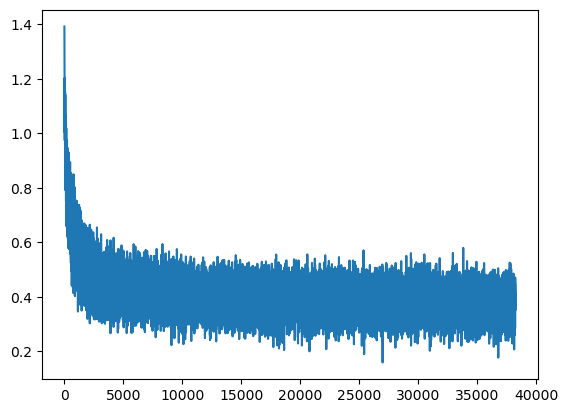

In [122]:

#print(loss.item())
plt.plot(stepi, lossi)

In [124]:
emb = C[Xval] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.5918, grad_fn=<NllLossBackward0>)

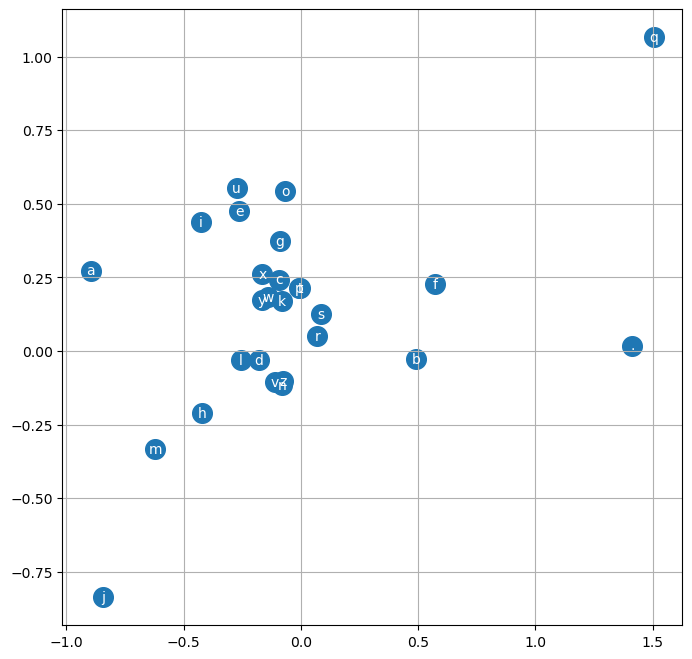

In [125]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')